In [1]:
import pandas as pd
import numpy as np
from numpy import absolute
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
import pickle
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree
from dtreeviz.trees import dtreeviz
import scipy.stats as sps
import itertools  

In [2]:
dftrain = pd.read_csv('Compressor_TrainData.csv')
dftest = pd.read_csv('Compressor_TestData.csv')

In [3]:
dftrain.columns

Index(['Timestamp', 'AIR COMPRESSOR DISCHARGE FLOW',
       'AIR COMPRESSOR DISCHARGE FLOW  ANTISURGE',
       'AIR COMPRESSOR POWER CONSUMPTION',
       'AIR COMP 1ST STAGE BEARING TEMPERATURE',
       'AIR COMP 1ST STAGE SUCTION TEMPERATURE',
       'AIR COMP 2ND STAGE BEARING TEMPERATURE',
       'AIR COMP 3RD STAGE BEARING TEMPERATURE',
       'AIR COMP 4TH STAGE BEARING TEMPERATURE',
       'AIR COMP DISCHARGE TEMPERATURE',
       'AIR COMP OIL TEMPERATURE AFTER COOLER',
       'AIR COMP MOTOR BEARING TEMPERATURE DRIVE END',
       'AIR COMP MOTOR BEARING TEMPERATURE N1 DRIVE END',
       'AIR COMP MAIN SHAFT AXIAL MOVEMENT',
       'AIR COMP 1ST STAGE BEARING VIBRATION',
       'AIR COMP 2ND STAGE BEARING VIBRATION',
       'AIR COMP 3TH STAGE BEARING VIBRATION',
       'AIR COMP 4TH STAGE BEARING VIBRATION',
       'AIR COMPRESSOR INLET GUIDE VANE POSITION'],
      dtype='object')

In [4]:
old_names = dftrain.columns
new_names = ['ts','df','dfa','pc','bt1','st','bt2','bt3','bt4','dt','otac','mbtde','mbtnde','msam','bv1','bv2','bv3','bv4','igvp']
dftrain.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [5]:
dftrain.head()

,ts,df,dfa,pc,bt1,st,bt2,bt3,bt4,dt,otac,mbtde,mbtnde,msam,bv1,bv2,bv3,bv4,igvp
0,12/31/2009 12:00,22491.88,1551.229,2789.708,74.80000,-9.172617,84.14831,89.54411,88.20000,10.48783,44.50000,64.78802,61.84773,0.170367,5.935430,3.532888,5.636122,9.233438,54.66384
1,12/31/2009 13:00,22900.41,1571.774,2858.471,74.80000,-9.211132,84.24268,89.53142,88.20000,10.46242,44.50000,64.75891,61.87130,0.174730,5.972112,3.572708,5.627361,9.243790,60.37223
2,12/31/2009 14:00,22437.93,1534.947,2785.800,74.80000,-9.249647,84.26951,89.51874,88.20000,10.43702,44.50000,64.72979,61.91320,0.175644,6.071956,3.612528,5.618600,9.254141,56.54831
3,12/31/2009 15:00,22451.98,1542.863,2773.099,74.80000,-9.288161,84.19181,89.50605,88.20000,10.41161,44.50000,64.70067,62.80007,0.171103,6.171800,3.652349,5.609840,9.264493,56.91230
4,12/31/2009 16:00,22430.27,1539.569,2802.031,74.77792,-9.617099,84.11411,89.50000,88.18479,10.39231,44.50419,64.67155,61.70258,0.172250,6.174306,3.644691,5.612414,9.261068,54.91096


In [6]:
needed = ['df','pc','bt1','st','bt2','bt3','bt4','dt','otac','mbtde','mbtnde','msam','bv1','bv2','bv3','bv4','igvp']
dft = dftrain[needed]

In [7]:
dft.head()

,df,pc,bt1,st,bt2,bt3,bt4,dt,otac,mbtde,mbtnde,msam,bv1,bv2,bv3,bv4,igvp
0,22491.88,2789.708,74.80000,-9.172617,84.14831,89.54411,88.20000,10.48783,44.50000,64.78802,61.84773,0.170367,5.935430,3.532888,5.636122,9.233438,54.66384
1,22900.41,2858.471,74.80000,-9.211132,84.24268,89.53142,88.20000,10.46242,44.50000,64.75891,61.87130,0.174730,5.972112,3.572708,5.627361,9.243790,60.37223
2,22437.93,2785.800,74.80000,-9.249647,84.26951,89.51874,88.20000,10.43702,44.50000,64.72979,61.91320,0.175644,6.071956,3.612528,5.618600,9.254141,56.54831
3,22451.98,2773.099,74.80000,-9.288161,84.19181,89.50605,88.20000,10.41161,44.50000,64.70067,62.80007,0.171103,6.171800,3.652349,5.609840,9.264493,56.91230
4,22430.27,2802.031,74.77792,-9.617099,84.11411,89.50000,88.18479,10.39231,44.50419,64.67155,61.70258,0.172250,6.174306,3.644691,5.612414,9.261068,54.91096


In [8]:
#function to learn how many clusters data can be grouped in to
def train_to_learn_clusters(clusters,features_data):
    wcss=[]
    for i in range(1,clusters):
        kmeans = KMeans(i)
        kmeans.fit(features_data)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    fig = plt.figure(figsize = (8,8))
    number_clusters = range(1,clusters)
    plt.subplot(1,3,1)
    plt.plot(number_clusters,wcss,marker='o')
    plt.title('The Elbow title')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
    i = 2
    sil = []
    cal = []
    while i<=clusters:
        k_means = KMeans(n_clusters=i)
        model = k_means.fit(features_data)
        y_predicted = k_means.predict(features_data)
        labels = k_means.labels_
        print(metrics.silhouette_score(features_data, labels, metric = 'euclidean'))
        sil.append(metrics.silhouette_score(features_data, labels, metric = 'euclidean'))
        print(metrics.calinski_harabasz_score(features_data, labels))
        cal.append(metrics.calinski_harabasz_score(features_data, labels))
        i = i + 1
        
    plt.subplot(1,3,2)
    plt.plot(number_clusters,sil,marker='o')
    plt.title('silhouette')
    plt.xlabel('Number of clusters')
    plt.ylabel('sil')
    
    plt.subplot(1,3,3)
    plt.plot(number_clusters,cal,marker='o')
    plt.title('calinski')
    plt.xlabel('Number of clusters')
    plt.ylabel('cal')
    
    
    plt.figure(figsize=(10, 7))
    plt.title("Dendograms")
    dend = shc.dendrogram(shc.linkage(features_data, method='ward'))
    
    return 

In [12]:
def fit_clustering(clusters,features_data,dfraw1):
    k_means = KMeans(n_clusters=clusters)
    model = k_means.fit(features_data)
    dfraw1['kmeans_predicted_'+str(clusters)] = k_means.predict(features_data)
    labels = k_means.labels_
    
    cluster = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')
    dfraw1['agglomerative_predicted_'+str(clusters)] = cluster.fit_predict(features_data)
    
    return dfraw1

In [30]:
def get_range(data):
    mu = data.mean()
    sigma = 25
    #n_bins = round(data.shape[0]/(data.max()-data.min()))
    n_bins = 100
    x = data
    fig, ax = plt.subplots(figsize=(8, 4))
    n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',cumulative=True, label='Empirical')
    # Overlay a reversed cumulative histogram.
    ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
            label='Reversed emp.')
    cnt = []
    cntf = []
    cnt.append(n[0])
    cntf.append(0)
    for i in range(1,n_bins):
        cnt.append(n[i]-n[i-1])
        if n[i] > n[i-1]: 
            if ((n[i] - n[i-1])/n[i-1]) > 0.001:
                cntf.append(1)
            else:
                cntf.append(0)
        else:
            cntf.append(0)
    memb = []
    meme = []
    j = 0
    for i in range(0,n_bins):
        if (cntf[i] == 1) & (j == 0):
            #print(i)
            j = i
            memb.append(i)
        else:
            if (cntf[i] == 0) & (j > 0):
                #print((sum(cntf[j:i+1])/len(cntf[j:i+1]))*100)
                if i > 6:
                    if ((sum(cntf[i-4:i+1])/len(cntf[i-4:i+1]))*100) < 20:
                        meme.append(i-4)
                        j = 0
                else:
                    if ((sum(cntf[j:i+1])/len(cntf[j:i+1]))*100) < 20:
                        meme.append(i-4)
                        j = 0
    if len(memb) > len(meme):
        meme.append(99)
    mem = []

    zip_object = zip(meme, memb)
    for meme_i, memb_i in zip_object:
        mem.append(meme_i-memb_i)
        
    startvalf = 0
    startval = 0
    endval = 0
    for i in range(0,len(mem)):
        if mem[i] > 1:
            if startvalf == 0:
                startvalf = 1
                startval = bins[memb[i]]
                endval = bins[meme[i]]
            else:
                endval = bins[meme[i]]

            #cntf = np.array(cnt) > 0.01
    return n,bins,cnt,cntf,mem,memb,meme,startval,endval

In [33]:
#train classification model
def build_classification(df,features,target,scaler_name,model_name):
    
    x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.25, random_state = 42)
    
    scaler = Normalizer().fit(x_train)
    scaler_filename = scaler_name +".save"
    joblib.dump(scaler, scaler_filename)
    
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test) 
    
    clf = DecisionTreeClassifier(random_state=1234)
    clf = clf.fit(x_train_scaled,y_train)
    
    dt_fn = model_name + ".save"
    joblib.dump(clf, dt_fn) 
    
    print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(x_test_scaled)))

    importance = clf.feature_importances_
    imp = pd.DataFrame()
    imp['features'] = features
    imp['importance'] = importance
    imp = imp.sort_values(by=['importance'], ascending=False)
    print(imp.head(25))
    
    return scaler,clf

In [9]:
features = needed
x = dft[features]
xscaler = Normalizer().fit(x)
xscaled = xscaler.transform(x)
scaler_filename = "scale_input.save"
joblib.dump(xscaler, scaler_filename)

['scale_input.save']

0.5562220442993875
31603.098693285676
0.47498982008042295
35820.75263950656
0.440272135086923
37286.29652758941
0.41025346666570206
38074.6749167185
0.37496480826732154
38085.46499793292
0.35261332456595135
37487.345724391336
0.3294358705780624
36226.834440938626


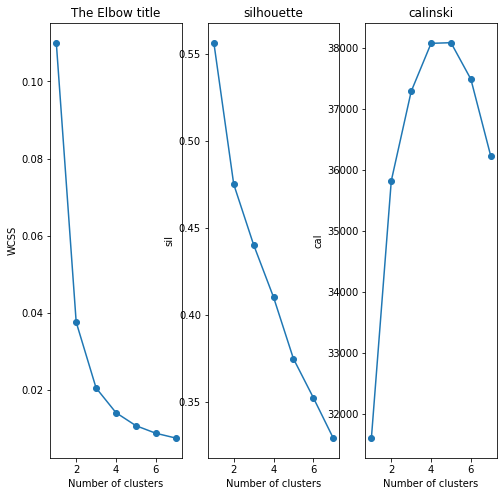

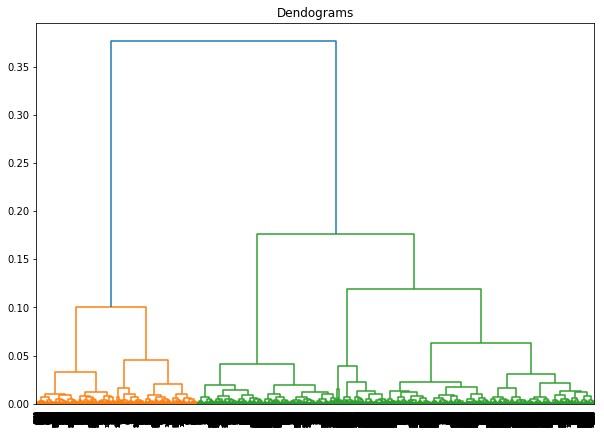

In [10]:
train_to_learn_clusters(8,xscaled)

In [13]:
dft = fit_clustering(5,xscaled,dft)

<ipython-input-12-01443f0f0f49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfraw1['kmeans_predicted_'+str(clusters)] = k_means.predict(features_data)


In [14]:
dft.head()

,df,pc,bt1,st,bt2,bt3,bt4,dt,otac,mbtde,mbtnde,msam,bv1,bv2,bv3,bv4,igvp,kmeans_predicted_5,agglomerative_predicted_5
0,22491.88,2789.708,74.80000,-9.172617,84.14831,89.54411,88.20000,10.48783,44.50000,64.78802,61.84773,0.170367,5.935430,3.532888,5.636122,9.233438,54.66384,3,4
1,22900.41,2858.471,74.80000,-9.211132,84.24268,89.53142,88.20000,10.46242,44.50000,64.75891,61.87130,0.174730,5.972112,3.572708,5.627361,9.243790,60.37223,3,4
2,22437.93,2785.800,74.80000,-9.249647,84.26951,89.51874,88.20000,10.43702,44.50000,64.72979,61.91320,0.175644,6.071956,3.612528,5.618600,9.254141,56.54831,3,4
3,22451.98,2773.099,74.80000,-9.288161,84.19181,89.50605,88.20000,10.41161,44.50000,64.70067,62.80007,0.171103,6.171800,3.652349,5.609840,9.264493,56.91230,0,1
4,22430.27,2802.031,74.77792,-9.617099,84.11411,89.50000,88.18479,10.39231,44.50419,64.67155,61.70258,0.172250,6.174306,3.644691,5.612414,9.261068,54.91096,3,4


In [15]:
dft['kmeans_predicted_5'].value_counts()

1    5073
4    4399
3    2693
2    2124
0    2068
Name: kmeans_predicted_5, dtype: int64

In [16]:
dft['agglomerative_predicted_5'].value_counts()

0    6072
2    4051
1    2385
4    2347
3    1502
Name: agglomerative_predicted_5, dtype: int64

<ipython-input-30-90d6d2ca9abf>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 4))


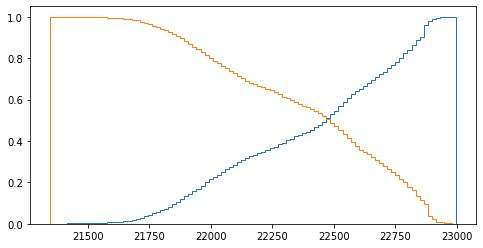

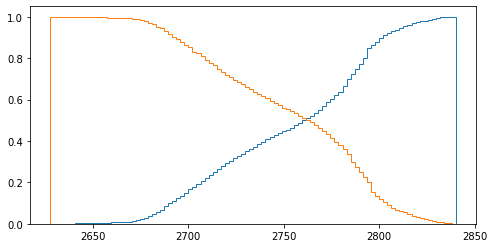

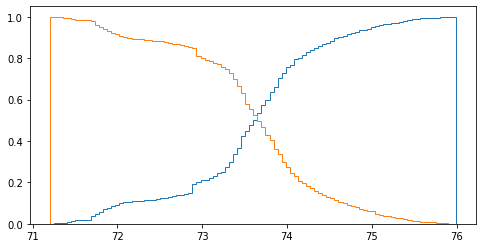

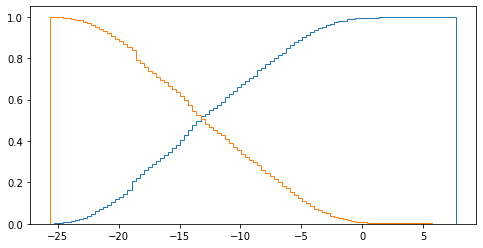

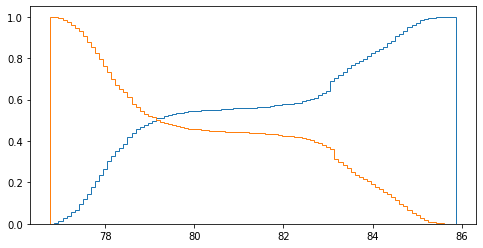

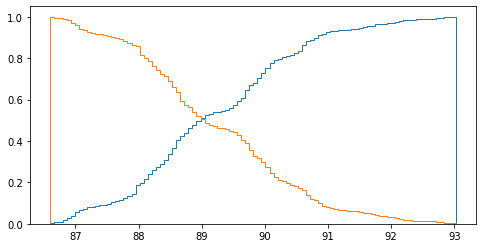

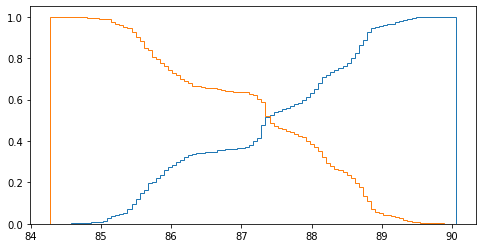

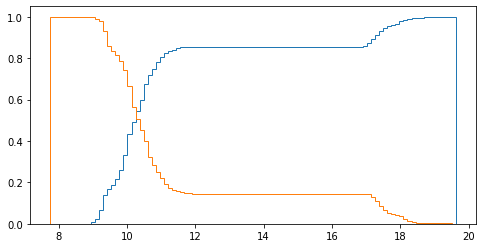

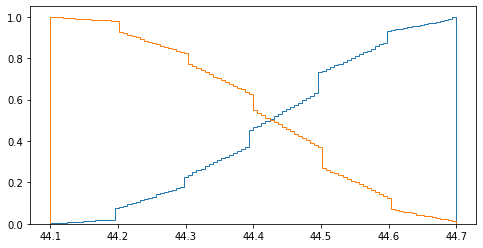

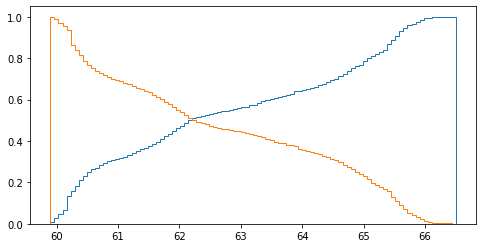

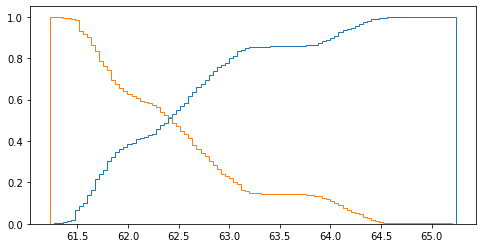

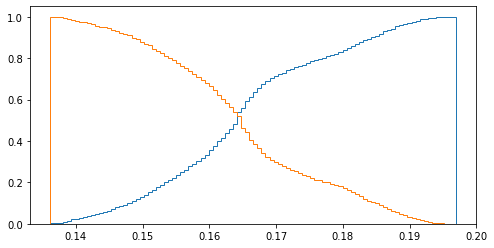

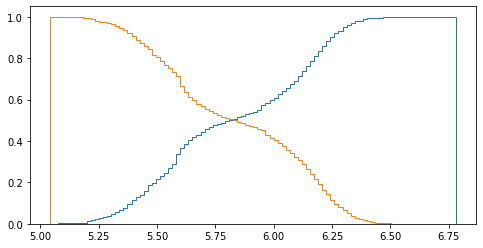

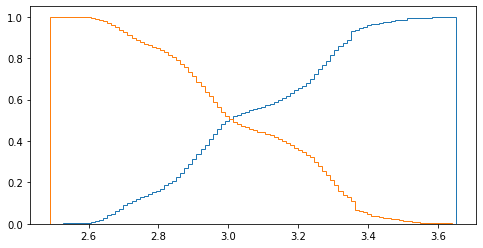

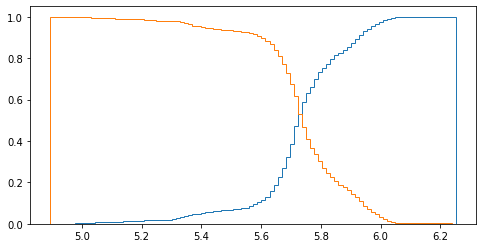

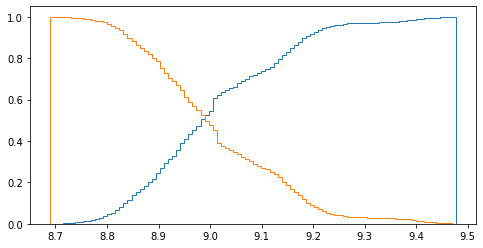

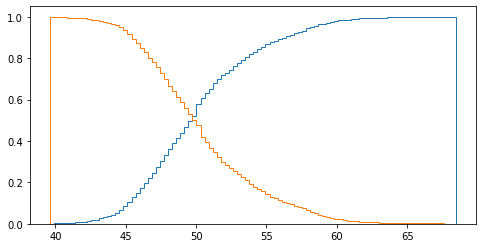

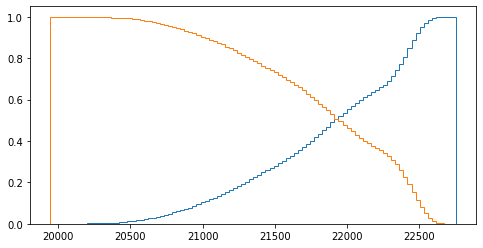

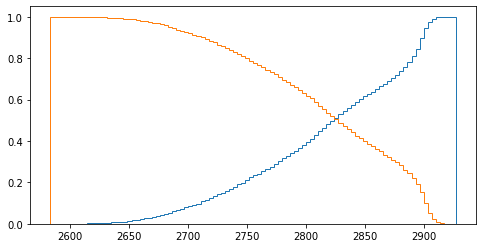

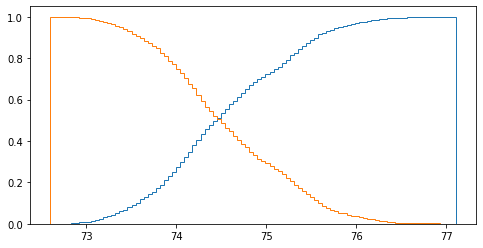

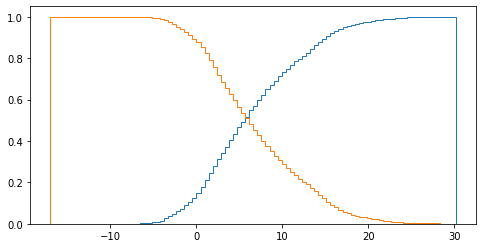

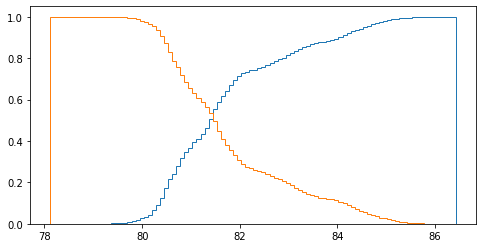

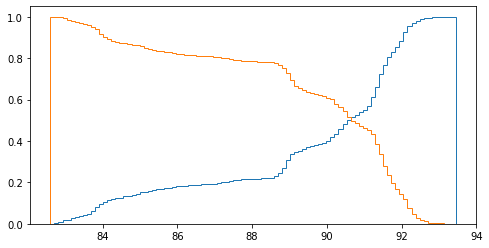

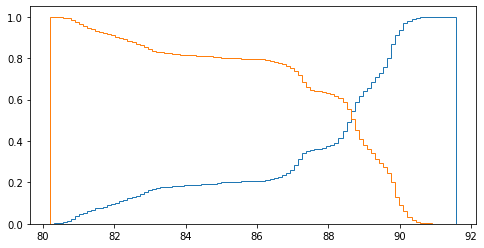

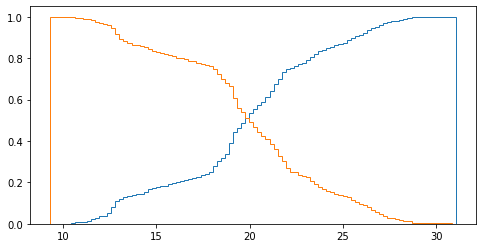

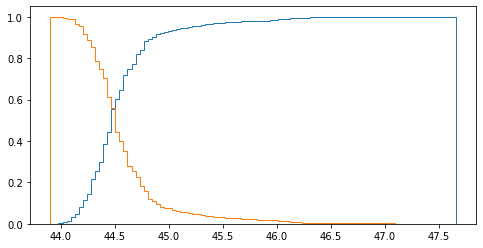

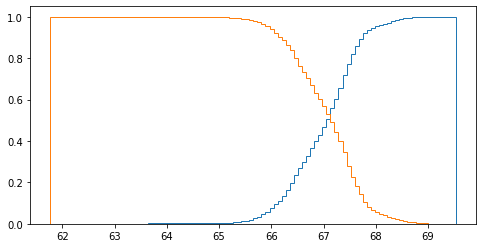

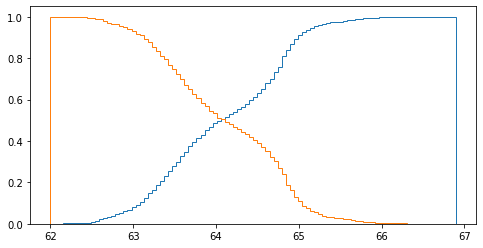

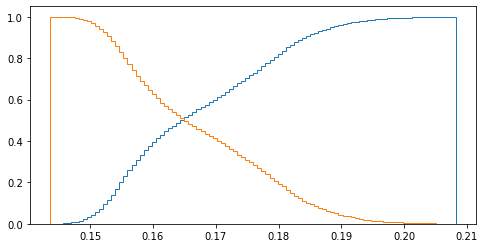

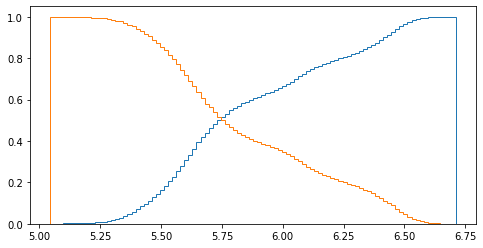

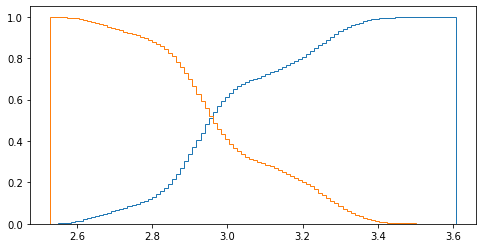

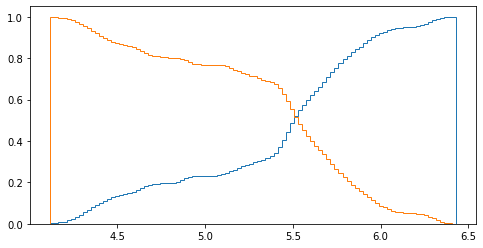

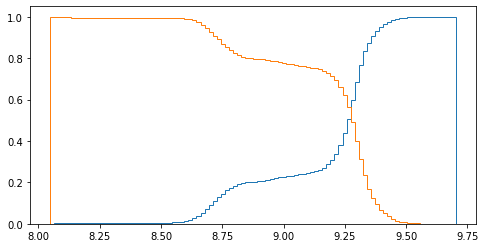

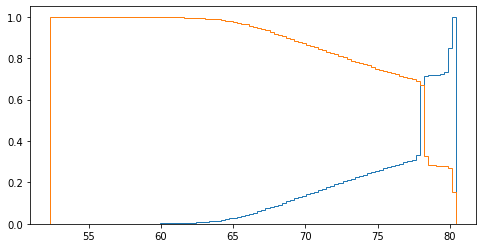

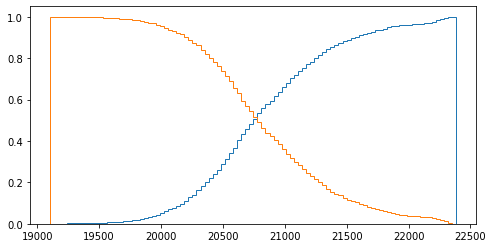

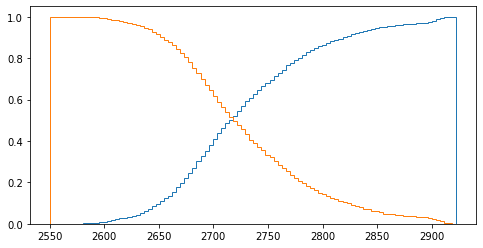

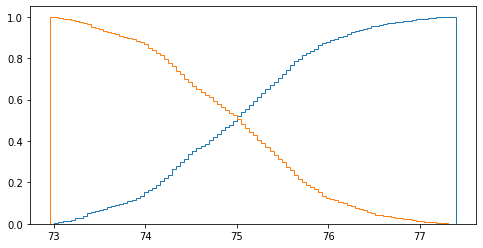

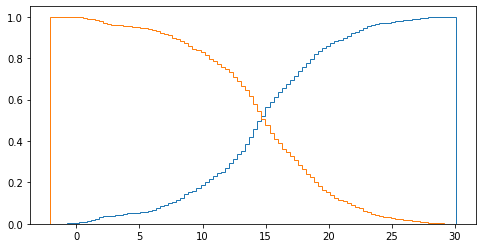

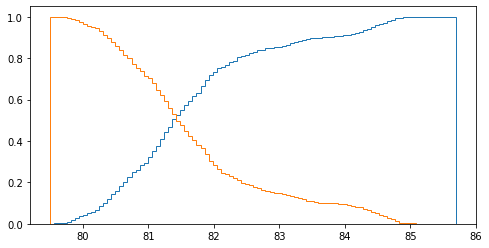

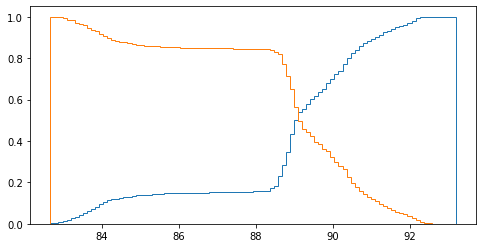

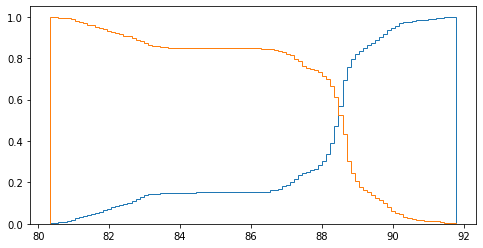

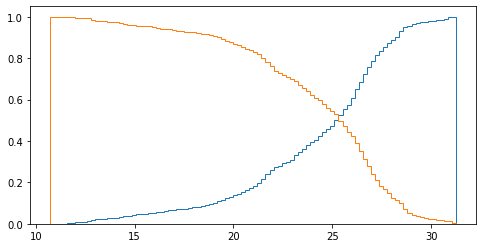

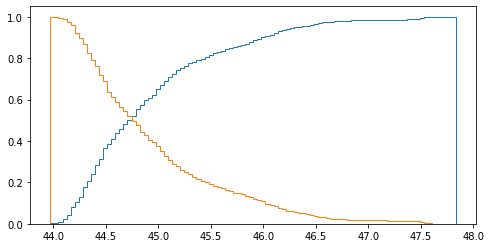

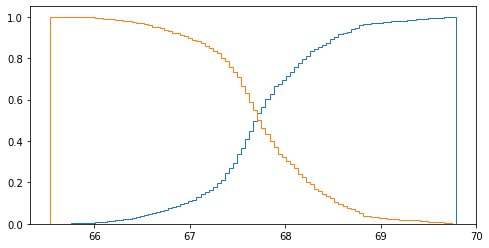

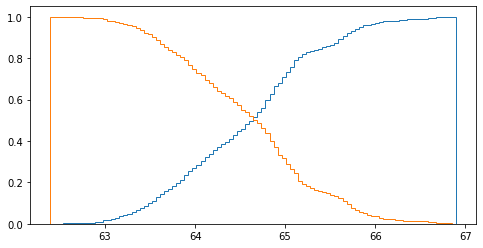

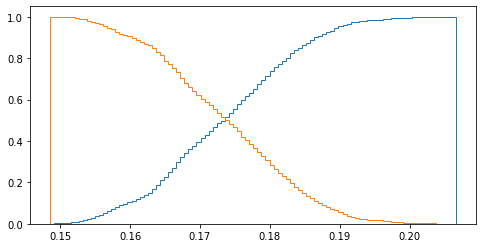

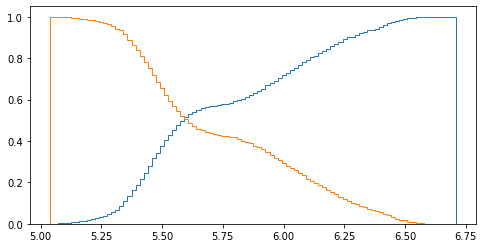

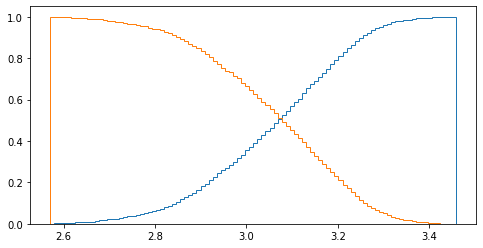

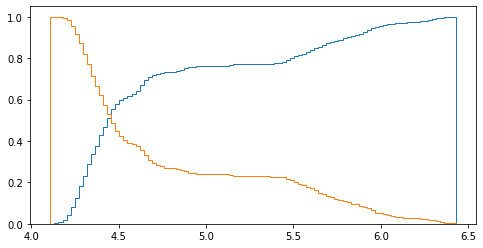

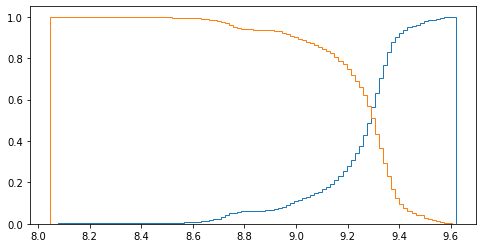

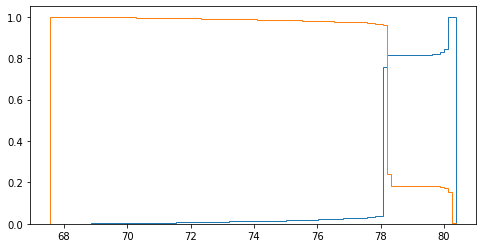

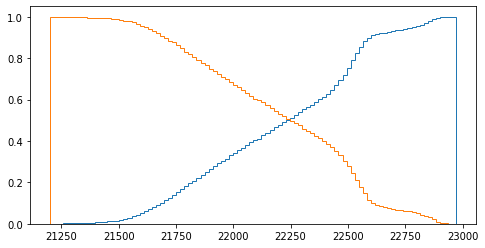

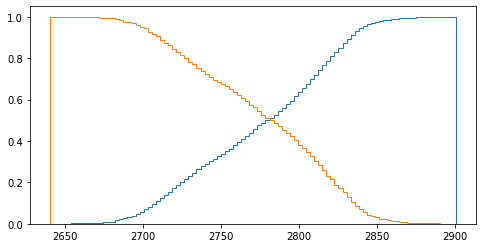

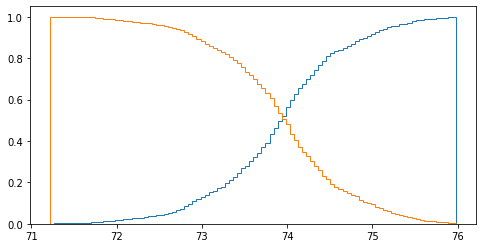

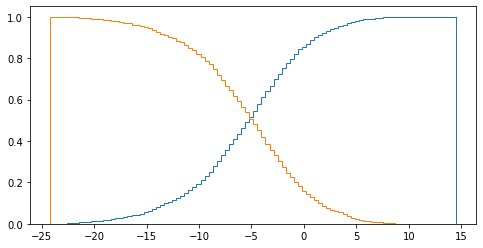

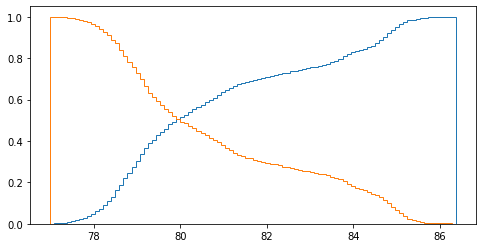

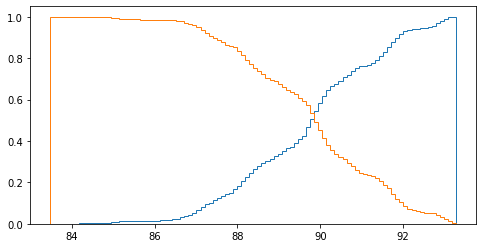

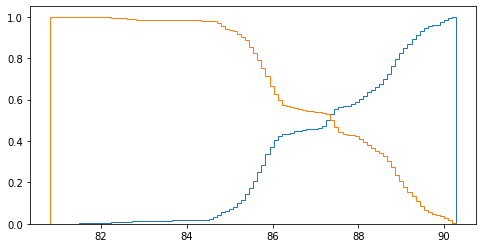

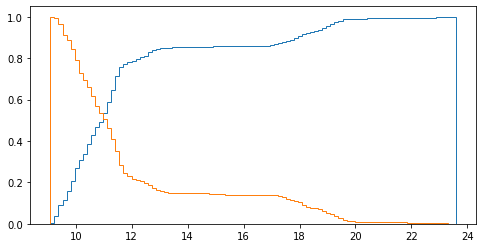

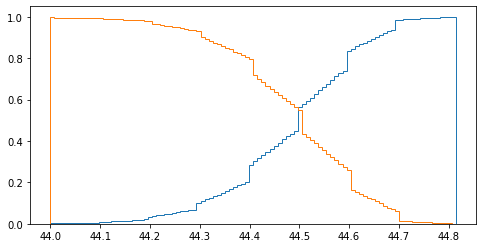

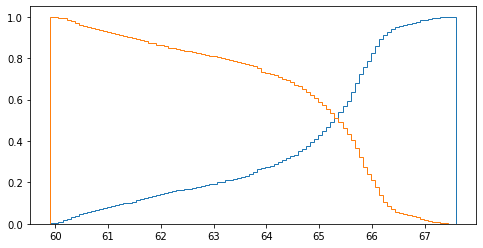

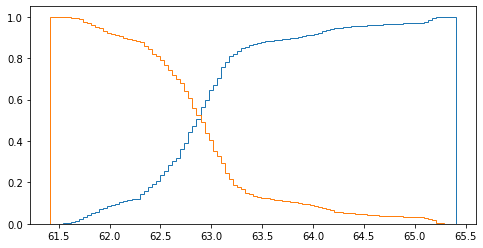

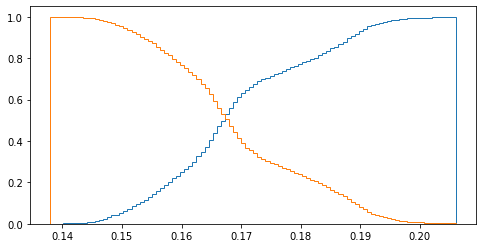

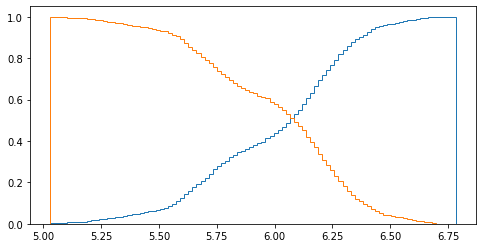

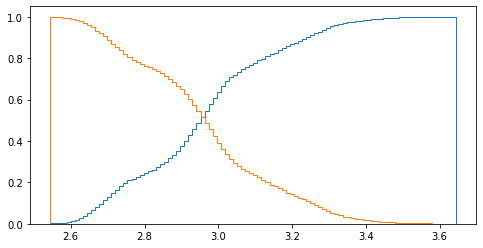

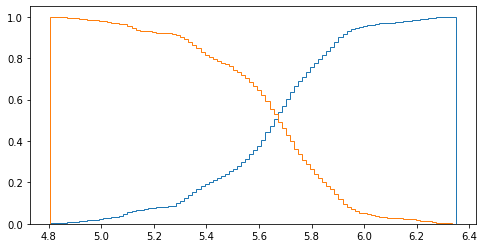

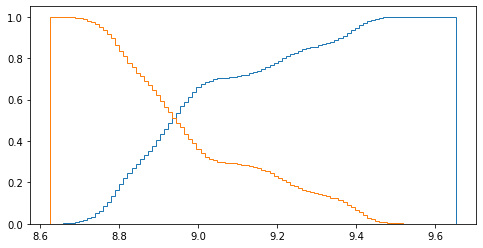

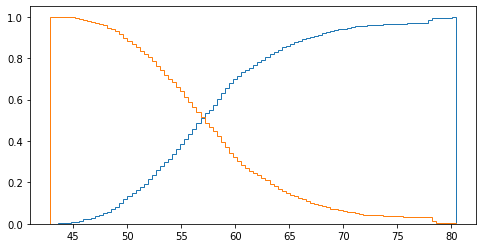

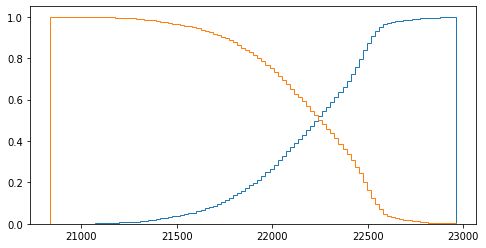

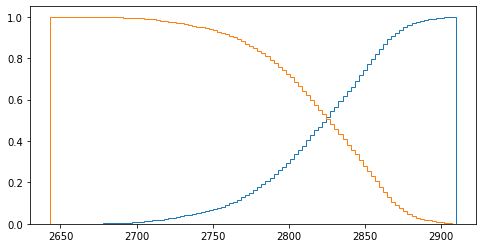

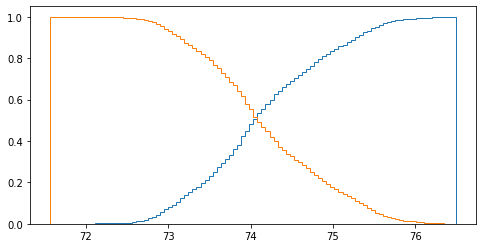

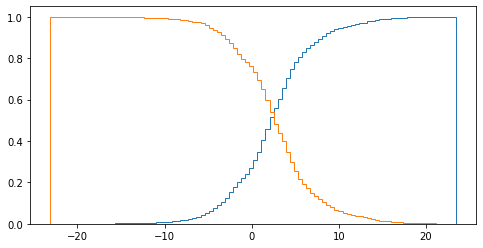

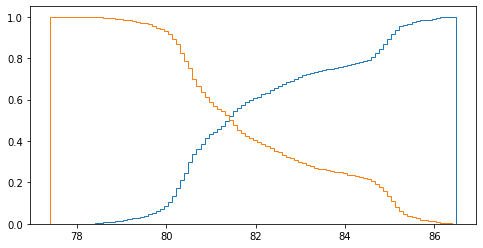

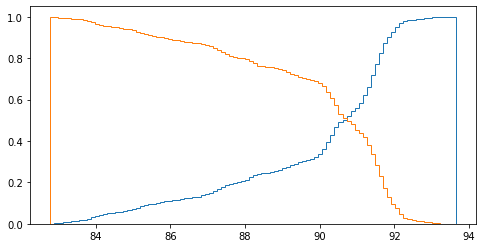

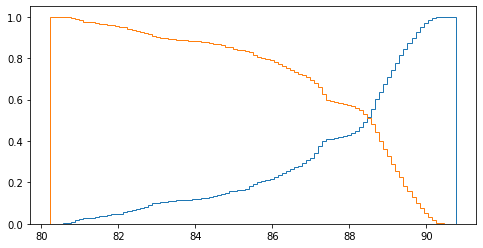

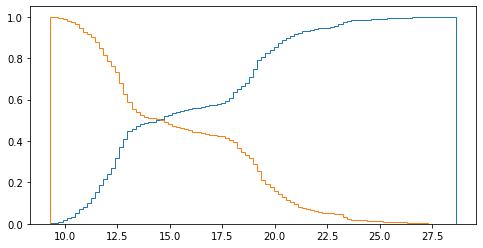

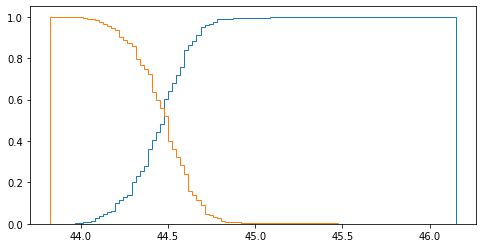

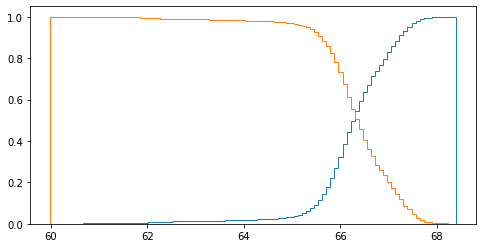

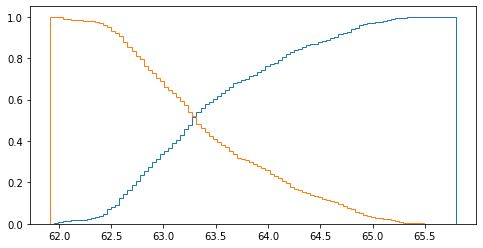

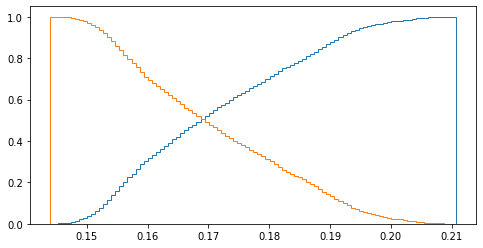

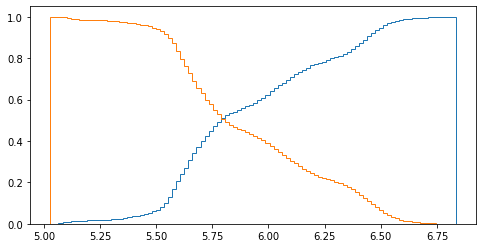

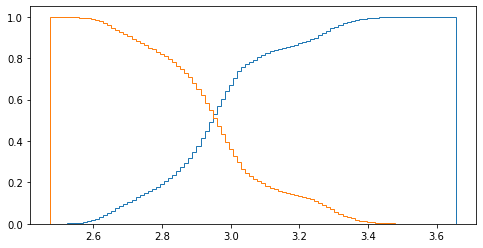

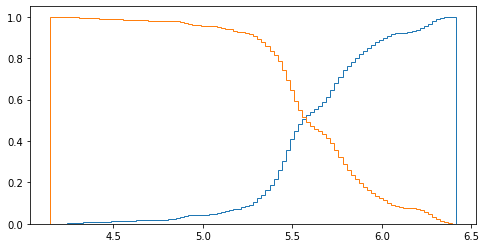

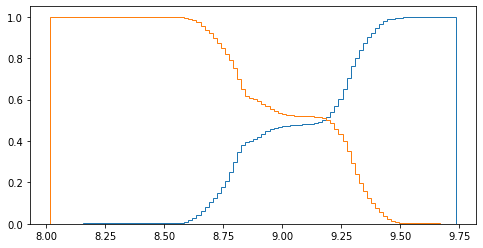

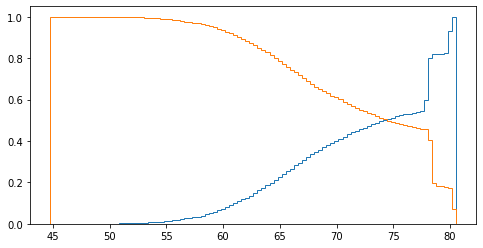

In [31]:
resdf = pd.DataFrame()
cols = ['df','pc','bt1','st','bt2','bt3','bt4','dt','otac','mbtde','mbtnde','msam','bv1','bv2','bv3','bv4','igvp']
for cls in range(0,5):
#for cls in range(0,1):
    clsdf = pd.DataFrame()
    clust = []
    colmn = []
    coln = []
    colbin = []
    colmem = []
    colmemb = []
    colmeme = []
    svl = []
    evl = []
    for col in cols:
    #for col in ['bt2']:
        #print(col)
        clust.append(cls)
        colmn.append(col)
        data = dft[dft['kmeans_predicted_5']==cls][col]
        #print(data[1:20])
        n,bins,cnt,cntf,mem,memb,meme,sv,ev = get_range(data)
        #print(n.shape)
        #print(n)
        #print(bins.shape)
        #print(bins)
        #print(cnt)
        #print(cntf)
        #print(memb)
        #print(meme)
        #print(mem)
        coln.append(n)
        colbin.append(bins)
        colmem.append(mem)
        colmemb.append(memb)
        colmeme.append(meme)
        svl.append(sv)
        evl.append(ev)
    clsdf['clust'] = clust
    clsdf['colmn'] = colmn
    clsdf['coln'] = coln
    clsdf['colbin'] = colbin
    clsdf['colmem'] = colmem
    clsdf['colmemb'] = colmemb
    clsdf['colmeme'] = colmeme
    clsdf['sv'] = svl
    clsdf['ev'] = evl
    resdf = pd.concat([resdf,clsdf],axis=0)

In [32]:
resdf[['clust','colmn','sv','ev']].head(60)

,clust,colmn,sv,ev
0,0,df,21412.745200,22982.031200
1,0,pc,2638.431450,2838.208710
2,0,bt1,71.258065,75.947845
3,0,st,-25.285431,1.718279
4,0,bt2,76.855567,85.786993
5,0,bt3,86.666205,92.966175
6,0,bt4,84.570786,89.538602
7,0,dt,8.944434,18.447568
8,0,otac,44.106000,44.694000
9,0,mbtde,59.966063,66.440227


In [36]:
features = ['df','pc','bt1','st','bt2','bt3','bt4','dt','otac','mbtde','mbtnde','msam','bv1','bv2','bv3','bv4','igvp']
scaler_name = 'comp_scaler'
model_name = 'comp_dt_cl'
comp_scaler, comp_dt_cl = build_classification(dft,features,'kmeans_predicted_5',scaler_name,model_name)
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(comp_dt_cl, 
#                   feature_names=features,  
#                   class_names=list(str(dft.kmeans_predicted_5).unique()),
#                   filled=True)
dft['comp_class_pred'] = comp_dt_cl.predict(comp_scaler.transform(dft[features]))
#fig.savefig("composition_decistion_tree.pdf")

Accuracy: 0.9850855745721271
   features  importance
0        df    0.774207
1        pc    0.174101
16     igvp    0.015729
3        st    0.011757
9     mbtde    0.008168
8      otac    0.005384
14      bv3    0.001812
2       bt1    0.001433
4       bt2    0.001379
15      bv4    0.001354
7        dt    0.001293
6       bt4    0.001073
13      bv2    0.001014
5       bt3    0.000475
12      bv1    0.000422
10   mbtnde    0.000295
11     msam    0.000106


In [38]:
dft.tail()

,df,pc,bt1,st,bt2,bt3,bt4,dt,otac,mbtde,mbtnde,msam,bv1,bv2,bv3,bv4,igvp,kmeans_predicted_5,agglomerative_predicted_5,comp_class_pred
16352,22343.91,2870.701,74.86731,5.273633,81.98996,91.47820,89.77728,21.34084,44.74552,67.59974,64.7,0.159535,5.607180,2.878413,5.746333,9.334004,77.60019,1,0,1
16353,22128.86,2864.109,75.05149,6.659359,81.97724,91.49089,89.78997,21.32812,44.77052,67.58743,64.7,0.160391,5.579588,2.891030,5.730235,9.368289,78.17642,1,0,1
16354,22215.48,2841.070,75.29707,7.800000,81.96453,91.48927,89.80266,21.31539,44.79553,67.57472,64.7,0.162693,5.569630,2.927857,5.730519,9.363829,78.17007,4,0,4
16355,22243.34,2863.921,75.54265,7.314820,81.95181,91.45118,89.81536,21.30267,44.80000,67.56202,64.7,0.159525,5.566578,2.914743,5.757528,9.341541,78.16371,1,0,1
16356,22266.97,2867.866,75.42839,7.342358,81.93910,91.41309,89.82806,21.28998,44.80000,67.54932,64.7,0.157885,5.586180,2.947532,5.733109,9.387826,78.15735,1,0,1


In [39]:
resdf[['clust','colmn','sv','ev']].to_csv('cluster_ranges.csv')

In [41]:
resdf.columns

Index(['clust', 'colmn', 'coln', 'colbin', 'colmem', 'colmemb', 'colmeme',
       'sv', 'ev'],
      dtype='object')